based on https://pureai.substack.com/p/recommender-systems-with-pytorch

In [ ]:
import sys
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing
from torch.utils.data import DataLoader, Dataset

In [ ]:
!wget -nc https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip -n ml-latest-small.zip

--2024-06-27 12:27:05--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.48MB/s    in 0.2s    

2024-06-27 12:27:06 (4.48 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
df = pd.read_csv('/content/ml-latest-small/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
df.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [ ]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [ ]:
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
df['userId'].unique(),df['userId'].nunique()

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178

In [ ]:
df['movieId'].nunique()

9724

In [ ]:
df.rating.value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

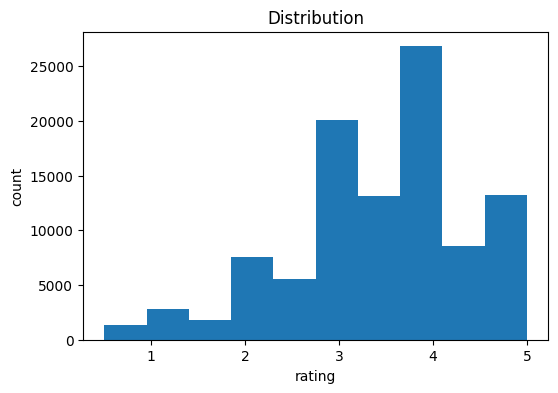

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(df['rating'])
plt.title('Distribution')
plt.xlabel('rating')
plt.ylabel('count')
plt.show()

In [ ]:
class MovielensDataset(Dataset):
    def __init__(self,users,movies,ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings

    def __len__(self):
        return len(self.users)

    def __getitem__(self,item):
        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]

        return {
            "users" : torch.tensor(users, dtype=torch.long),
            "movies" : torch.tensor(movies, dtype=torch.long),
            "ratings" : torch.tensor(ratings, dtype=torch.float)
        }


In [ ]:
class RecommendationSystemModel(nn.Module):
    def __init__(
            self,
            num_users,
            num_movies,
            embedding_size=256,
            hidden_dim=256,
            dropout_rate=0.2
    ):
        super(RecommendationSystemModel, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(p=dropout_rate)

        self.user_embedding = nn.Embedding(num_embeddings = self.num_users, embedding_dim = self.embedding_size)
        self.movies_embedding = nn.Embedding(num_embeddings = self.num_movies, embedding_dim = self.embedding_size)

        self.relu = nn.ReLU()

        self.first_layer = nn.Linear(self.embedding_size*2, hidden_dim)
        self.second_layer = nn.Linear(hidden_dim, 1)

    def forward(self,users,movies):
        users_embedded = self.user_embedding(users)
        movies_embedded = self.movies_embedding(movies)

        combined = torch.cat([users_embedded, movies_embedded], dim=1)

        return self.second_layer(self.dropout(self.relu(self.first_layer(combined))))

In [ ]:
le_movies = preprocessing.LabelEncoder()
le_users = preprocessing.LabelEncoder()

df['movieId'] = le_movies.fit_transform(df['movieId'].values)
df['userId'] = le_users.fit_transform(df['userId'].values)

df_train, df_test = model_selection.train_test_split(df, test_size = 0.2, random_state = 24, stratify = df['rating'].values)

train_dataset = MovielensDataset(
    users = df_train['userId'].values,
    movies = df_train['movieId'].values,
    ratings = df_train['rating'].values
)

test_dataset = MovielensDataset(
    users = df_test['userId'].values,
    movies = df_test['movieId'].values,
    ratings = df_test['rating'].values
)

In [ ]:
df_train.shape, df_test.shape

((80668, 4), (20168, 4))

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 8)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
le_movies.classes_, le_users.classes_

(array([     1,      2,      3, ..., 193585, 193587, 193609]),
 array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167

In [ ]:
recommendation_model = RecommendationSystemModel(
    num_users = len(le_users.classes_),
    num_movies = len(le_movies.classes_),
    embedding_size = 64,
    hidden_dim = 128,
    dropout_rate = 0.2
).to(device)

optimizer = torch.optim.Adam(params = recommendation_model.parameters(), lr = 0.001)
loss_fn = nn.MSELoss()

In [ ]:
for i, batch in enumerate(train_loader):
    if i<5:
        print(f'{i}:{batch}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0:{'users': tensor([303, 452, 296, 121, 452, 598, 273,  18, 379, 590, 427,   3,  83, 245,
        579, 523, 135, 605, 310, 571, 508, 413, 473, 356, 473, 181, 598, 367,
        131, 596, 273, 479]), 'movies': tensor([1978, 2427, 1136, 8287, 1182, 5282, 2439,  358, 1067, 2916, 3008, 2543,
         470, 1235, 2353,  126,  197, 1294,  908, 1072, 6416, 3946, 1307, 5439,
        3949,  833, 6142, 2309, 5324,  982, 4633,  307]), 'ratings': tensor([5.0000, 4.0000, 1.0000, 5.0000, 4.0000, 3.0000, 3.0000, 2.0000, 4.0000,
        4.0000, 2.5000, 4.0000, 3.0000, 4.0000, 3.5000, 3.0000, 2.0000, 4.0000,
        2.5000, 4.0000, 3.5000, 4.0000, 3.5000, 5.0000, 3.5000, 4.0000, 2.0000,
        2.0000, 3.5000, 4.0000, 3.0000, 3.0000])}
1:{'users': tensor([ 63, 216, 297, 451, 317, 571, 609, 287, 216, 379, 588, 483, 381,  94,
        119, 482, 297, 287, 599,  94, 598, 209, 437,   5, 413,  18, 124, 181,
        371, 598, 410, 134]), 'movies': tensor([2992, 1967,   92,  830, 6625, 1602,  694, 1813,  954, 593

In [ ]:
epochs = 5

def log_progress(epoch, step, total_loss, log_progress_step, datasize, losses):
    avg_loss = total_loss / log_progress_step
    sys.stderr.write(f'\r{epoch+1:02d}/{epochs:02d} | Step: {step}/{datasize} | Avg loss: {avg_loss:<6.9f}')
    sys.stderr.flush()
    losses.append(avg_loss)

In [ ]:
len(train_loader)

2521

In [ ]:
total_loss = 0
log_progress_step = 100
datasize = len(train_dataset)
losses = []
print(f"Training on {datasize} samples...")

for epoch in range(epochs):
    step_count = 0
    recommendation_model.train()
    for i, train_data in enumerate(train_loader):
        output = recommendation_model(train_data['users'].to(device), train_data['movies'].to(device))
        output = output.squeeze()
        ratings = train_data['ratings'].to(torch.float32).to(device).squeeze()

        loss = loss_fn(output,ratings)
        total_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_count += len(train_data['users'])

        if (step_count%log_progress_step == 0 or i == len(train_loader)-1):
            log_progress(epoch, step_count, total_loss, log_progress_step, datasize, losses)
            total_loss = 0



Training on 80668 samples...


05/05 | Step: 80668/80668 | Avg loss: 0.154053077

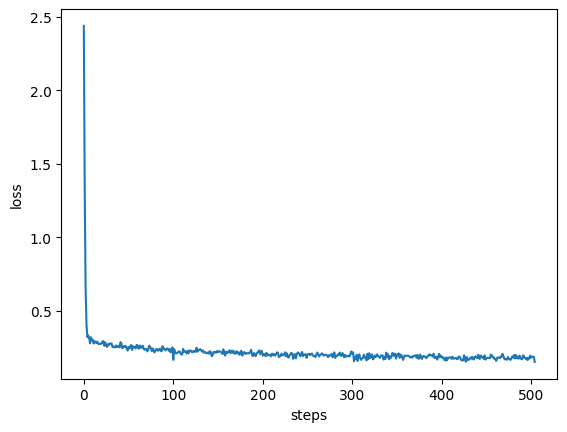

In [ ]:
plt.figure()
plt.plot([loss.detach().numpy() for loss in losses])
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = []
y_true = []

recommendation_model.eval()

with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        output = recommendation_model(test_data['users'].to(device),test_data['movies'].to(device))
        output = output.squeeze()
        ratings = test_data['ratings'].to(device)

        y_pred.extend(output.numpy())
        y_true.extend(ratings.numpy())

rms = mean_squared_error(y_true,y_pred, squared = False)
print(f"RMS: {rms:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RMS: 0.8939


In [ ]:
df_movies = pd.read_csv('/content/ml-latest-small/movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
all_movies = df['movieId'].unique().tolist()
ran_user = 24
seen_movies = set(df[df['userId']==ran_user]['movieId'].tolist())

In [ ]:
l = []
l.extend(zip([1,2,3,4,5],['a','b','c','d','e']))
l

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd'), (5, 'e')]

In [ ]:
def recommend_top_movies(recommendation_model, user_id, seen_movies, all_movies, batch_size = 100, k=5):
    recommendation_model.eval()
    unseen_movies = [m for m in all_movies if m not in seen_movies]
    predictions = []

    with torch.no_grad():
        for i in range(0,len(unseen_movies),batch_size):
            batch_unseen_movies = unseen_movies[i:i+batch_size]
            user_tensor = torch.tensor([user_id]*len(batch_unseen_movies)).to(device)
            movie_tensor = torch.tensor(batch_unseen_movies).to(device)
            predicted_ratings = recommendation_model(user_tensor,movie_tensor).view(-1).tolist()
            predictions.extend(zip(batch_unseen_movies, predicted_ratings))

        predictions.sort(key= lambda x: x[1], reverse=True)
        top_predictions = [movie_id for movie_id, i in predictions[:k]]
        return top_predictions

In [ ]:
def get_movies_with_genres(movie_ids, df_movies):
    movies_with_genres = df_movies[df_movies['movieId'].isin(movie_ids)].copy()
    movies_with_genres['titles - genres'] = movies_with_genres[['title','genres']].agg(' - '.join, axis=1)
    return movies_with_genres['titles - genres'].tolist()

In [ ]:
recommendations = recommend_top_movies(recommendation_model, ran_user, seen_movies, all_movies)
recommendations_with_genres = get_movies_with_genres(recommendations, df_movies)

user_top_ten_seen_movies = df[df['userId'] == ran_user].sort_values(by="rating", ascending=False).head(10)
seen_movies_with_genres = get_movies_with_genres(user_top_ten_seen_movies['movieId'], df_movies)

print(f"Recommended movies:\n\n{recommendations_with_genres}\n\nbased on these movies the user has watched:\n\n{seen_movies_with_genres}")

Recommended movies:

['It Happened One Night (1934) - Comedy|Romance', 'After Hours (1985) - Comedy|Thriller']

based on these movies the user has watched:

['Don Juan DeMarco (1995) - Comedy|Drama|Romance', 'Bubba Ho-tep (2002) - Comedy|Horror', 'Hannah and Her Sisters (1986) - Comedy|Drama|Romance', 'Battle Royale (Batoru rowaiaru) (2000) - Action|Drama|Horror|Thriller']
